## AUTHOR : ADITYA KUMAR ROY 

## LOAD LIBRARIES

In [2]:
library(readr)
library(dplyr)
library(ggplot2)
library(caret)
library(randomForest)
library(gbm)
library(pROC)
library(GGally)
library(reshape2)
library(tidyr)
library(car)

Warning message:
"package 'dplyr' was built under R version 4.4.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'ggplot2' was built under R version 4.4.3"
Warning message:
"package 'caret' was built under R version 4.4.3"
Loading required package: lattice

Warning message:
"package 'lattice' was built under R version 4.4.3"
Warning message:
"package 'randomForest' was built under R version 4.4.3"
randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine


Loaded gbm 2.2.2

This version of gbm is no longer under development. Consider transitioning to gbm3, https://github.com/gbm-developers/gbm3

Type 'citation("pROC")' fo

## DATA PRE-PROCESSING 

In [6]:
# Read Data
churn <- read_csv("C:/Users/DJ COMPUTERS/OneDrive/Desktop/Churnpredictor/Churn_Modelling.csv")

# Drop irrelevant columns
churn <- churn %>% select(-RowNumber, -CustomerId, -Surname)

# Convert Categorical Variables
churn$Gender <- as.factor(churn$Gender)
churn$Geography <- as.factor(churn$Geography)
churn$Exited <- as.factor(churn$Exited)
table(churn$Exited)

# Check missing values
sum(is.na(churn))

Rows: 10000 Columns: 14
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Surname, Geography, Gender
dbl (11): RowNumber, CustomerId, CreditScore, Age, Tenure, Balance, NumOfPro...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



   0    1 
7963 2037 

[1] 0

## DATA ANALYSIS

In [8]:
str(churn)
summary(churn)

tibble [10,000 × 11] (S3: tbl_df/tbl/data.frame)
 $ CreditScore    : num [1:10000] 619 608 502 699 850 645 822 376 501 684 ...
 $ Geography      : Factor w/ 3 levels "France","Germany",..: 1 3 1 1 3 3 1 2 1 1 ...
 $ Gender         : Factor w/ 2 levels "Female","Male": 1 1 1 1 1 2 2 1 2 2 ...
 $ Age            : num [1:10000] 42 41 42 39 43 44 50 29 44 27 ...
 $ Tenure         : num [1:10000] 2 1 8 1 2 8 7 4 4 2 ...
 $ Balance        : num [1:10000] 0 83808 159661 0 125511 ...
 $ NumOfProducts  : num [1:10000] 1 1 3 2 1 2 2 4 2 1 ...
 $ HasCrCard      : num [1:10000] 1 0 1 0 1 1 1 1 0 1 ...
 $ IsActiveMember : num [1:10000] 1 1 0 0 1 0 1 0 1 1 ...
 $ EstimatedSalary: num [1:10000] 101349 112543 113932 93827 79084 ...
 $ Exited         : Factor w/ 2 levels "0","1": 2 1 2 1 1 2 1 2 1 1 ...


  CreditScore      Geography       Gender          Age            Tenure      
 Min.   :350.0   France :5014   Female:4543   Min.   :18.00   Min.   : 0.000  
 1st Qu.:584.0   Germany:2509   Male  :5457   1st Qu.:32.00   1st Qu.: 3.000  
 Median :652.0   Spain  :2477                 Median :37.00   Median : 5.000  
 Mean   :650.5                                Mean   :38.92   Mean   : 5.013  
 3rd Qu.:718.0                                3rd Qu.:44.00   3rd Qu.: 7.000  
 Max.   :850.0                                Max.   :92.00   Max.   :10.000  
    Balance       NumOfProducts    HasCrCard      IsActiveMember  
 Min.   :     0   Min.   :1.00   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:     0   1st Qu.:1.00   1st Qu.:0.0000   1st Qu.:0.0000  
 Median : 97199   Median :1.00   Median :1.0000   Median :1.0000  
 Mean   : 76486   Mean   :1.53   Mean   :0.7055   Mean   :0.5151  
 3rd Qu.:127644   3rd Qu.:2.00   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :250898   Max.   :4.00   Max.   :1.00

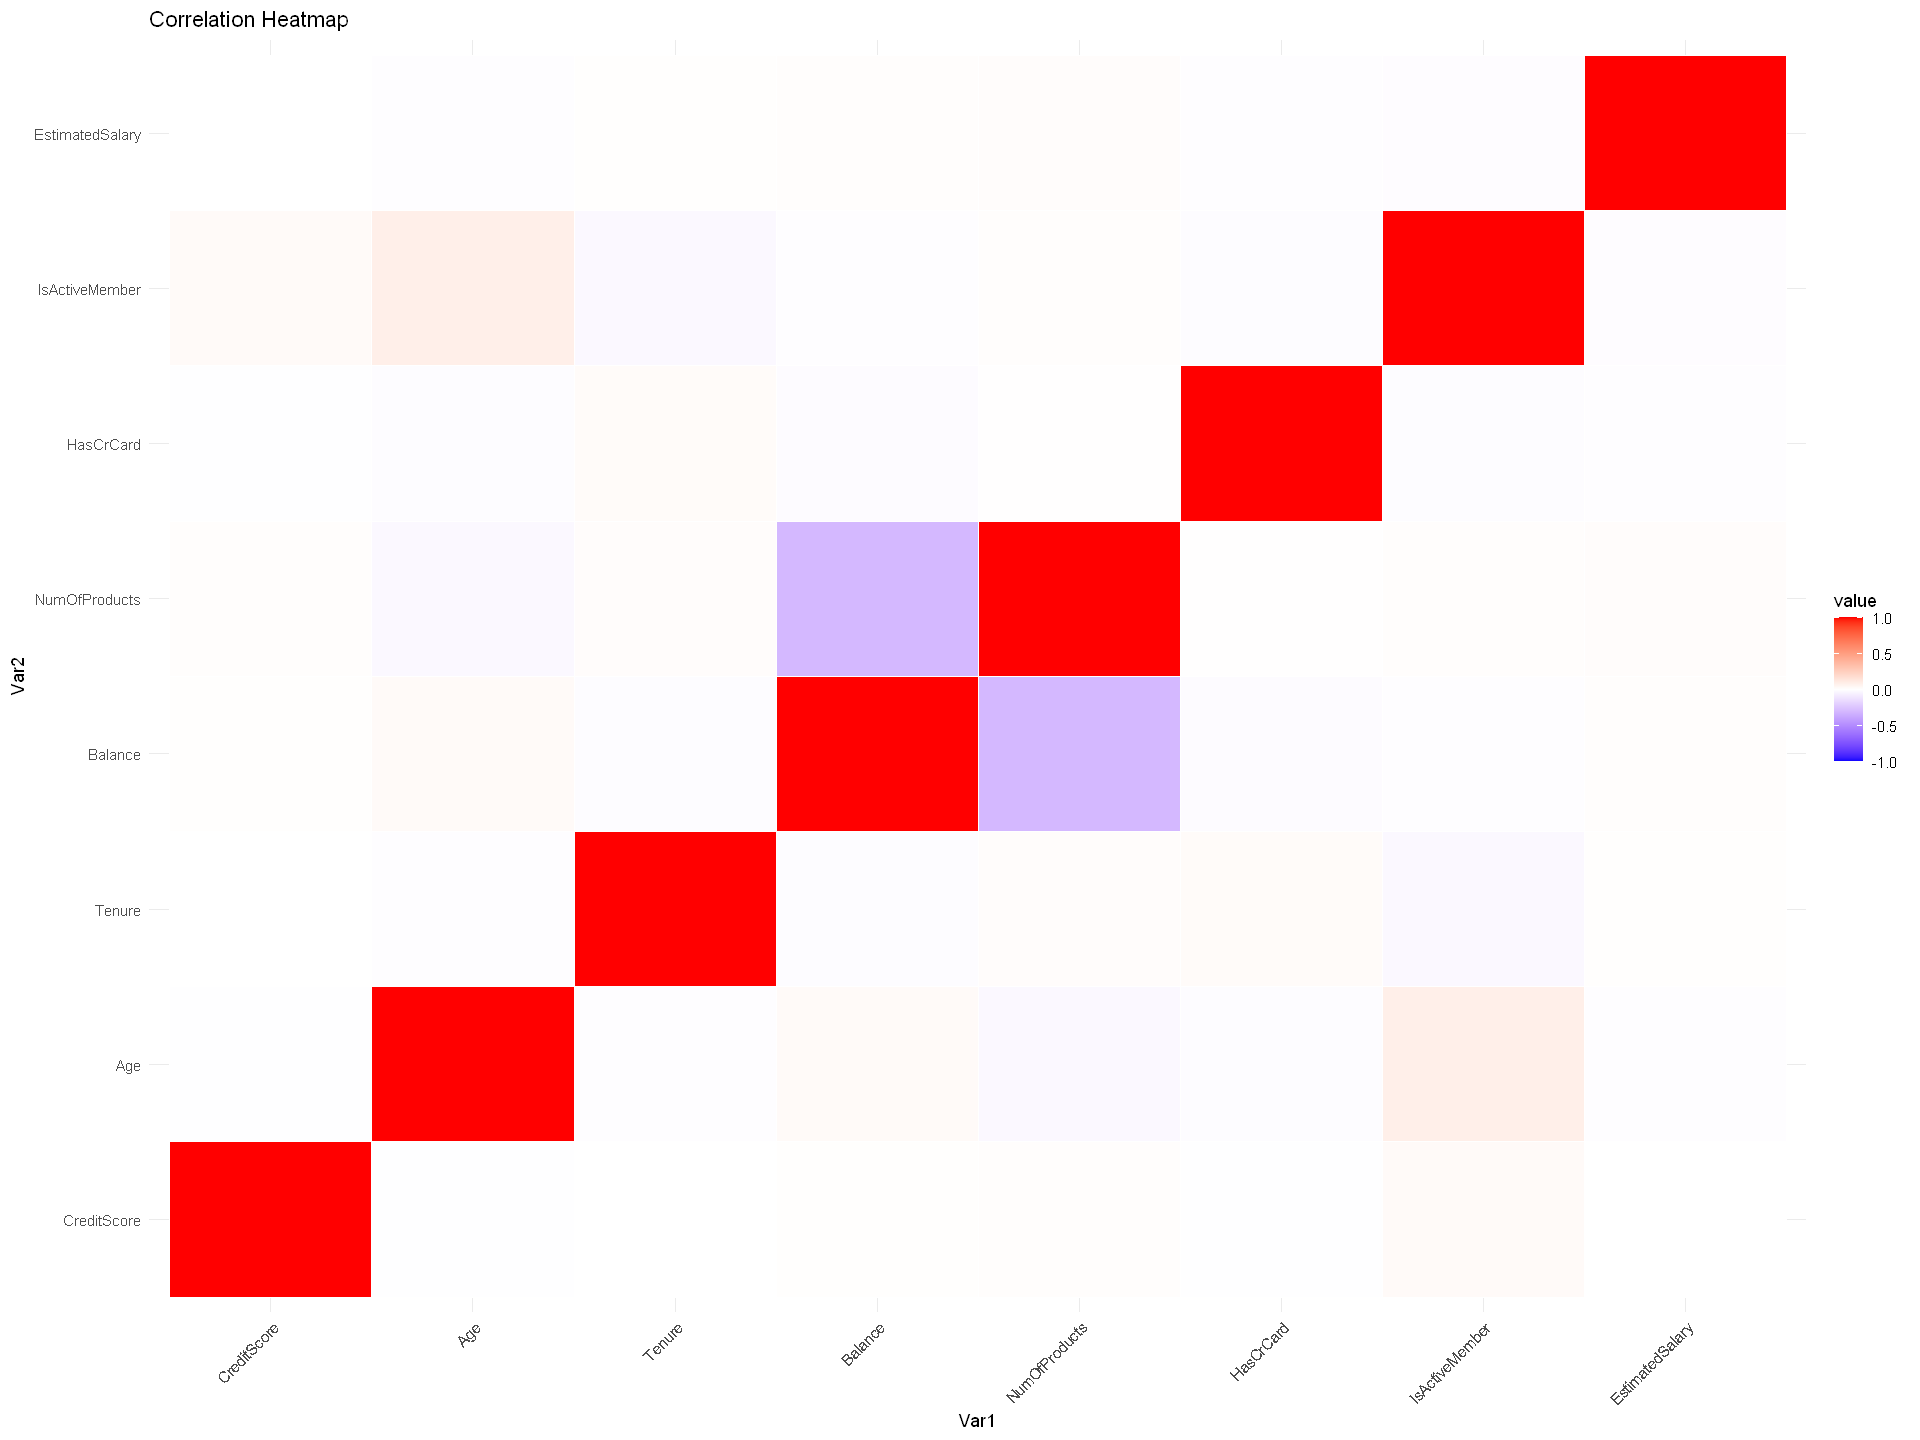

In [12]:
# Correlation for numeric features
numeric_cols <- churn %>% select(where(is.numeric))
cor_matrix <- cor(numeric_cols)
melted_cor <- melt(cor_matrix)

# Correlation Heatmap
options(repr.plot.width = 16, repr.plot.height = 12) # setting the plot window
ggplot(data = melted_cor, aes(x=Var1, y=Var2, fill=value)) +
  geom_tile(color="white") +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0, limit=c(-1,1)) +
  theme_minimal() + ggtitle("Correlation Heatmap") + theme(axis.text.x = element_text(angle = 45, hjust = 1))


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


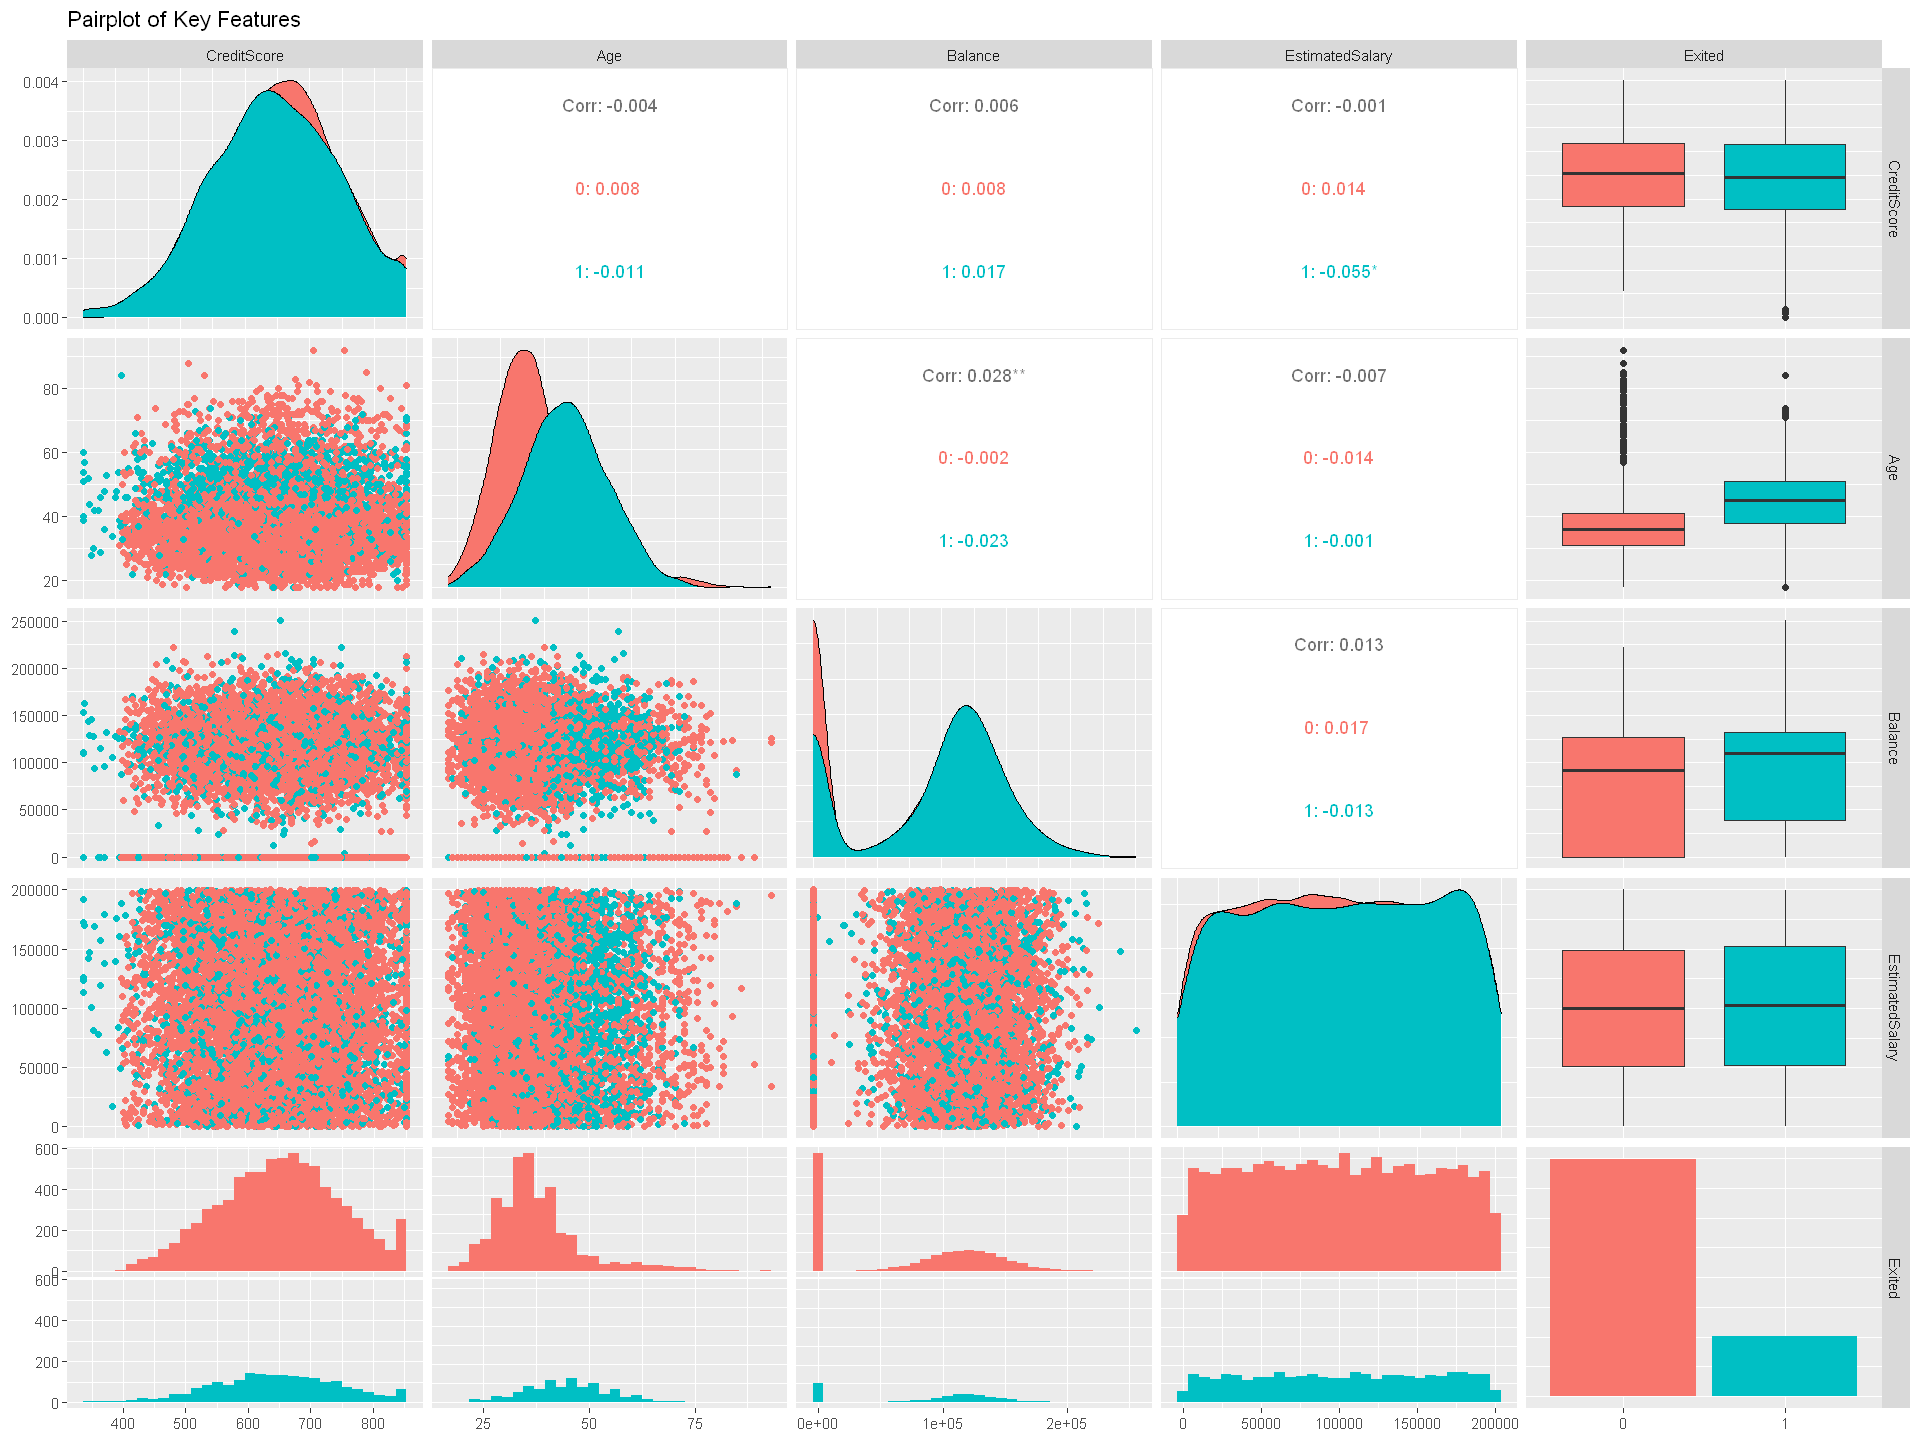

In [13]:
# Pairplot for high correlation factors 
# Pairplot
ggpairs(churn[, c("CreditScore", "Age", "Balance", "EstimatedSalary", "Exited")],
        mapping=ggplot2::aes(color=Exited), title="Pairplot of Key Features")


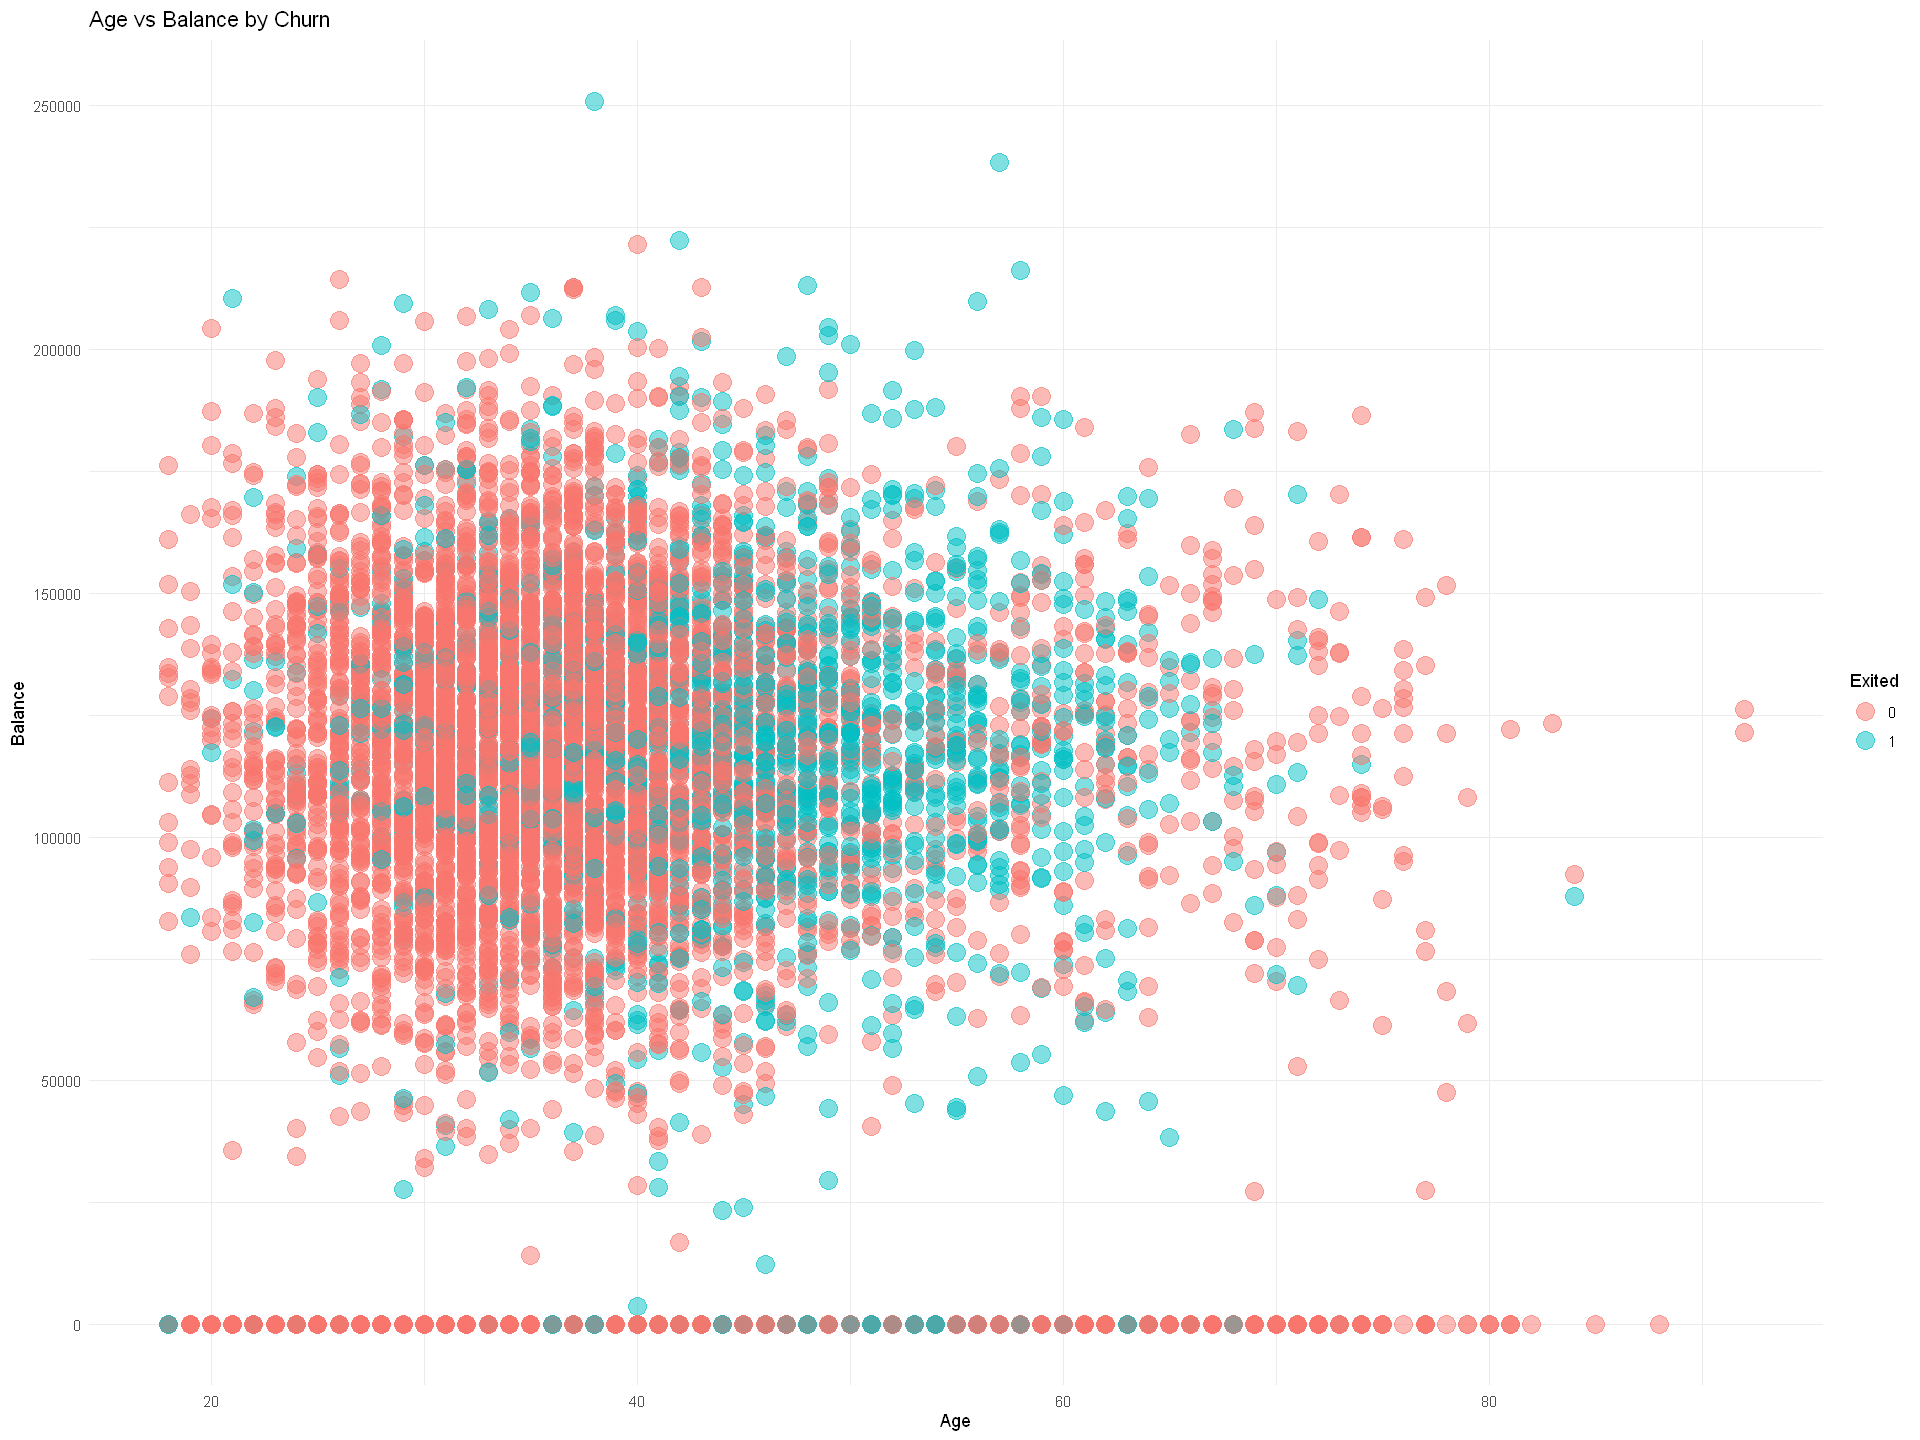

In [15]:
# Scatterplot: Age vs Balance
ggplot(churn, aes(x=Age, y=Balance, color=Exited)) +
  geom_point(alpha=0.5,size = 5) + theme_minimal() + ggtitle("Age vs Balance by Churn")
#  INSIGHT : Age > 40 churn increases


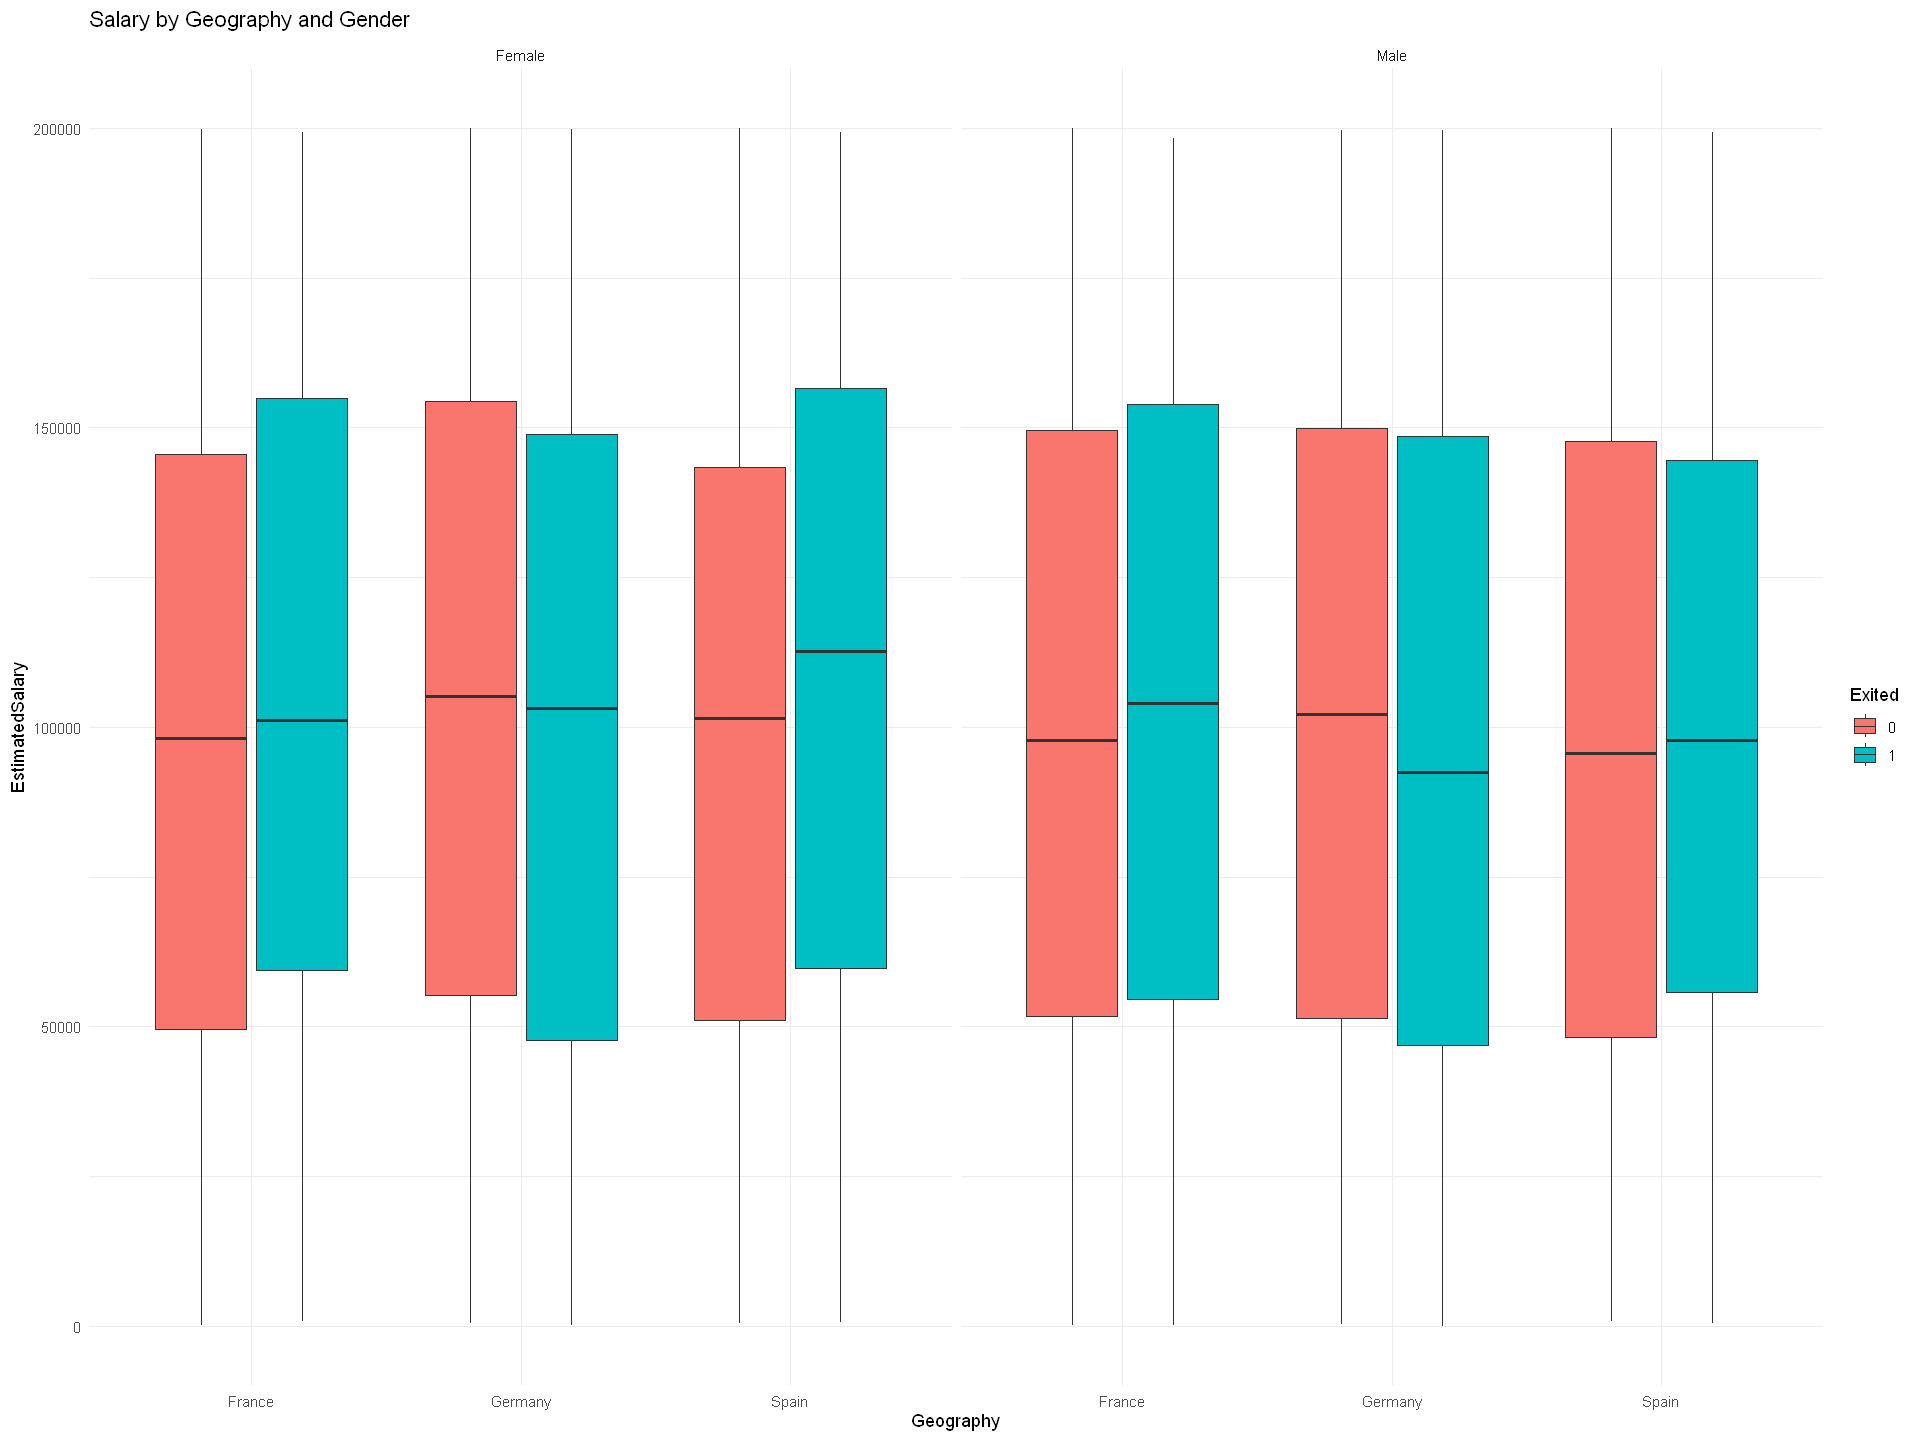

In [16]:
# Facet Wrap: Geography vs EstimatedSalary
ggplot(churn, aes(x=Geography, y=EstimatedSalary, fill=Exited)) +
  geom_boxplot() + facet_wrap(~Gender) + theme_minimal() +
  ggtitle("Salary by Geography and Gender")  
#INSIGHT : females in Spain  have high churn ratio. Overall, Germany has high churn ratio.


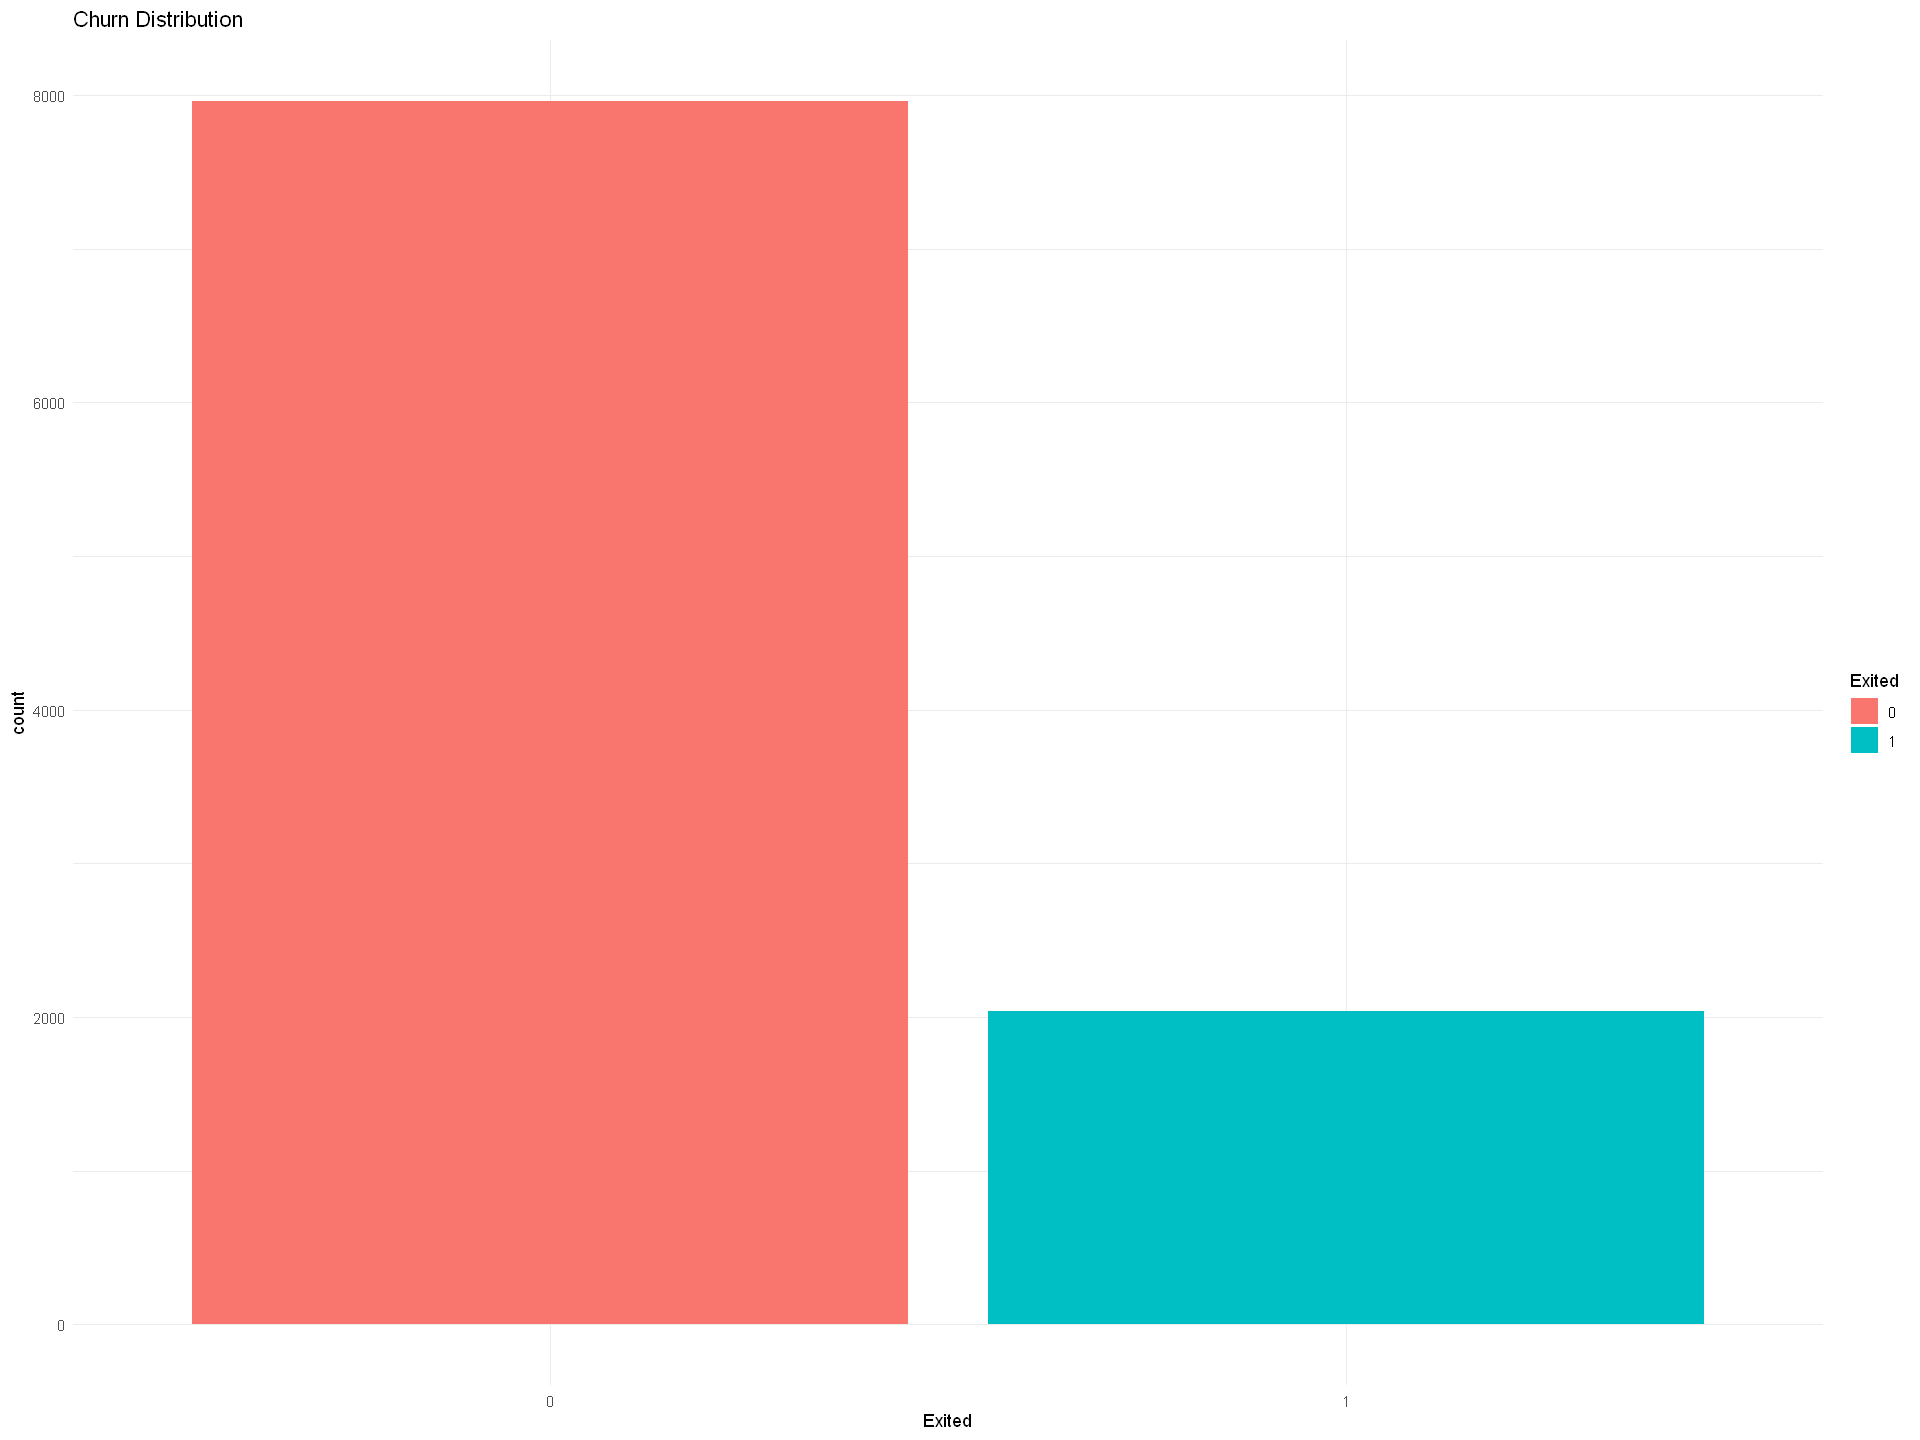

In [17]:
# Class Distribution
ggplot(churn, aes(x=Exited, fill=Exited)) +
  geom_bar() + theme_minimal() + ggtitle("Churn Distribution")

#INSIGHT : bank is able to retain its customer to an extent.


## DATA PARTITION

In [18]:
set.seed(123)
index <- createDataPartition(churn$Exited, p=0.7, list=FALSE)
train <- churn[index, ]  
test <- churn[-index, ]

## LOGISTIC REGRESSION MODEL TRAINING


Threshold: 0.1 
Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0  926   65
         1 1462  546
                                          
               Accuracy : 0.4908          
                 95% CI : (0.4728, 0.5089)
    No Information Rate : 0.7963          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.152           
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.8936          
            Specificity : 0.3878          
         Pos Pred Value : 0.2719          
         Neg Pred Value : 0.9344          
             Prevalence : 0.2037          
         Detection Rate : 0.1821          
   Detection Prevalence : 0.6696          
      Balanced Accuracy : 0.6407          
                                          
       'Positive' Class : 1               
       

Setting levels: control = 1, case = 2

Setting direction: controls < cases



Area under the curve: 0.7796

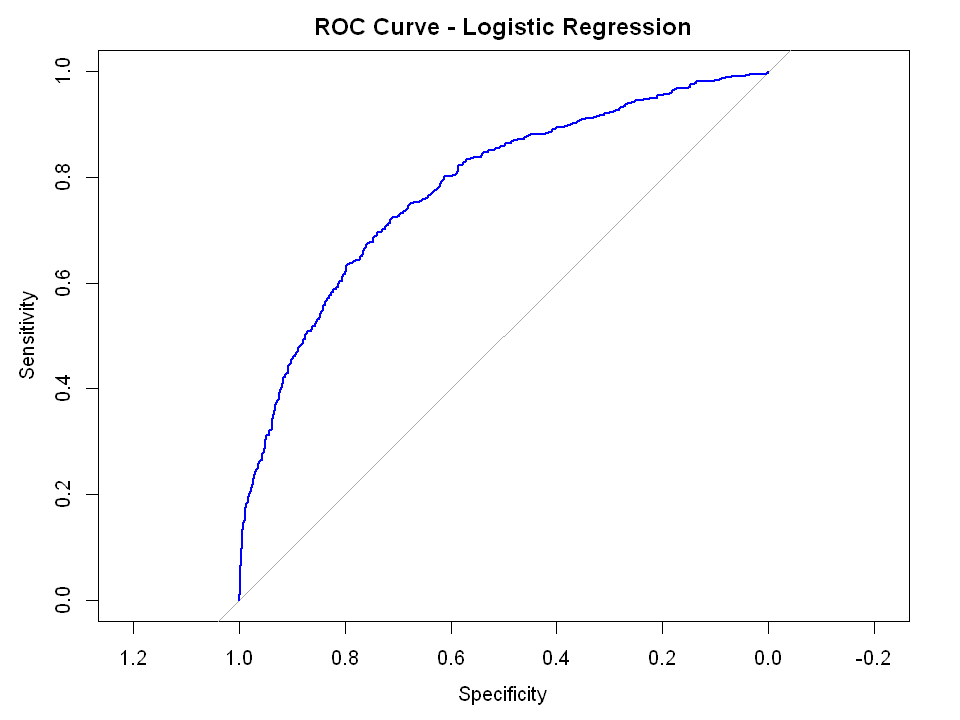

In [21]:
log_model <- glm(Exited ~ ., data = train, family = binomial)   # TRAINING THE MODEL
log_pred <- predict(log_model, newdata = test, type = "response")  # PREDICTING 

# FINDING APPROPRIATE THRESHOLD VALUE
thresholds <- seq(0.1, 0.9, by = 0.1)

for (t in thresholds) {
  log_pred_class <- ifelse(log_pred > t, 1, 0)
  log_pred_class <- factor(log_pred_class, levels = levels(test$Exited))
  
  cm <- confusionMatrix(log_pred_class, test$Exited, positive = "1")
  cat("\nThreshold:", t, "\n")
  print(cm)
} # threshold of 0.5

# PLOTTING ROC CURVE 
options(repr.plot.width = 8, repr.plot.height = 6) # setting the plot window
log_roc <- roc(as.numeric(test$Exited), as.numeric(log_pred))
plot(log_roc, col="blue", main="ROC Curve - Logistic Regression")
auc(log_roc)

# THUS ,THE MODEL WITH 0.5 THRESHOLD IS THE MOST OPTIMIZED ONE.

In [25]:
# MOST OPTIMIZED MODEL

log_pred_class <- ifelse(log_pred > 0.5, 1, 0)
log_pred_class <- factor(log_pred_class, levels = levels(test$Exited))
confusionMatrix(log_pred_class, test$Exited, positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2323  470
         1   65  141
                                          
               Accuracy : 0.8216          
                 95% CI : (0.8074, 0.8352)
    No Information Rate : 0.7963          
    P-Value [Acc > NIR] : 0.0002563       
                                          
                  Kappa : 0.2702          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.23077         
            Specificity : 0.97278         
         Pos Pred Value : 0.68447         
         Neg Pred Value : 0.83172         
             Prevalence : 0.20373         
         Detection Rate : 0.04702         
   Detection Prevalence : 0.06869         
      Balanced Accuracy : 0.60177         
                                          
       'Positive' Class : 1               
                        

## RANDOM FOREST REGRESSOR MODEL

In [26]:
tunegrid <- expand.grid(.mtry = c(2, 3, 4, 5))
control <- trainControl(method="cv", number=5, search="grid")
set.seed(123)
rf_tuned <- train(Exited ~ ., data=train, method="rf",
                  metric="Accuracy", tuneGrid=tunegrid, trControl=control)

print(rf_tuned)
rf_pred <- predict(rf_tuned, newdata=test)
confusionMatrix(rf_pred, test$Exited, positive = "1")


Random Forest 

7001 samples
  10 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 5600, 5601, 5601, 5601, 5601 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.8557358  0.4473415
  3     0.8591642  0.4840385
  4     0.8583071  0.4900987
  5     0.8584508  0.4943209

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 3.


Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2322  332
         1   66  279
                                          
               Accuracy : 0.8673          
                 95% CI : (0.8546, 0.8792)
    No Information Rate : 0.7963          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5119          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.45663         
            Specificity : 0.97236         
         Pos Pred Value : 0.80870         
         Neg Pred Value : 0.87491         
             Prevalence : 0.20373         
         Detection Rate : 0.09303         
   Detection Prevalence : 0.11504         
      Balanced Accuracy : 0.71450         
                                          
       'Positive' Class : 1               
                        

## MOST IMPORTANT FACTOR 

Top Predictors of Customer Churn:
[1] "Age"             "Balance"         "NumOfProducts"   "EstimatedSalary"
[5] "CreditScore"    


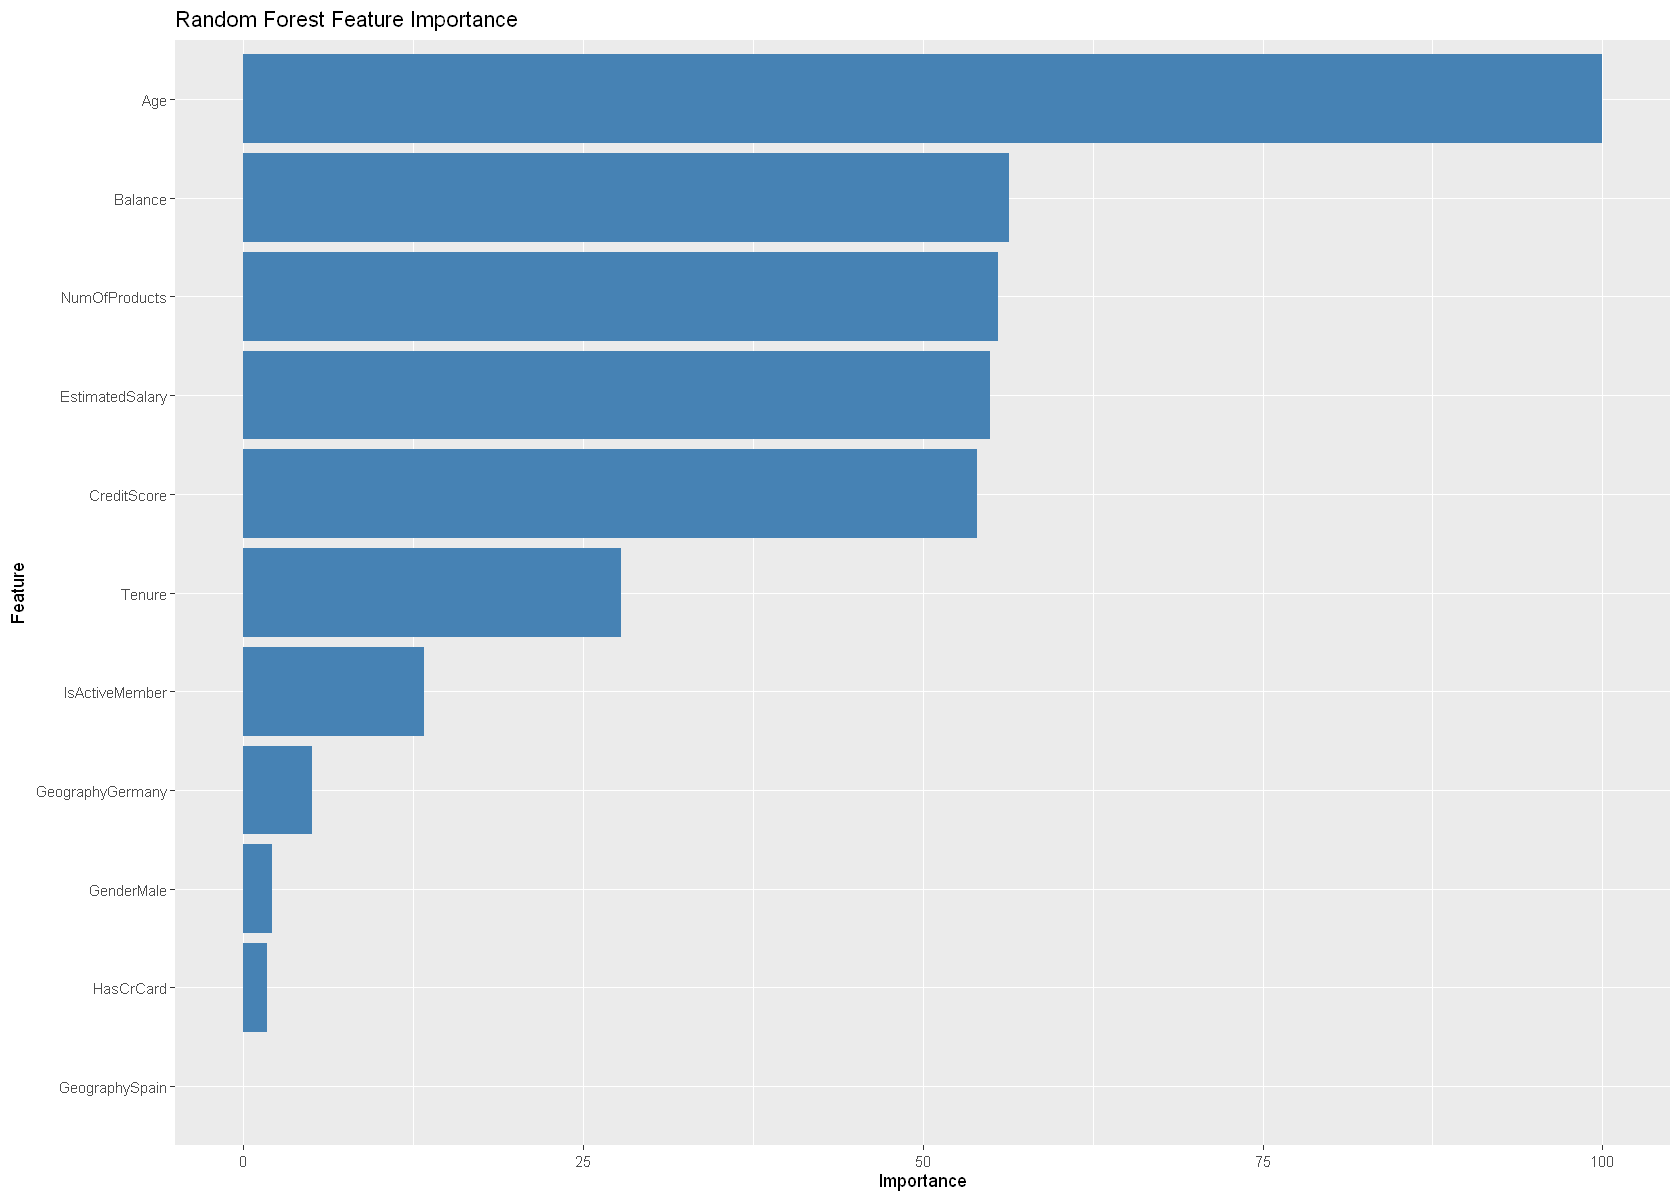

In [28]:
# Feature Importance Plot
imp <- varImp(rf_tuned)$importance
imp$Feature <- rownames(imp)
options(repr.plot.width = 14, repr.plot.height = 10) # setting the plot window

ggplot(imp, aes(x=reorder(Feature, Overall), y=Overall)) +
  geom_col(fill="steelblue") + coord_flip() +
  labs(title="Random Forest Feature Importance", x="Feature", y="Importance")

# Most important predictors from Random Forest
top_features <- rownames(imp[order(-imp$Overall),])[1:5]
cat("Top Predictors of Customer Churn:\n")
print(top_features)

## SAVING THE MODEL FOR FURTHER USES

In [30]:
saveRDS(rf_tuned,"rf_tuned.rds")